# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [464]:
# Import libraries
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, \
                                  avg, from_unixtime, split, min, max, round, lit, mean
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

#from pyspark.sql.types import IntegerType, TimestampType
import datetime
from pyspark.sql.functions import to_date, year, month, dayofmonth, dayofweek, hour, date_format, substring

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Set time parser policy
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

### Common Functions

In [4]:
# Set plot's figure size
def set_plot_size(width, height):
    return plt.figure(figsize = [width, height]);

def get_user_logs(userId, sessionId=None):
    if sessionId == None:
        return data.where(data.userId == userId) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')
    else:
        return data.where((data.userId == userId) & (data.sessionId == sessionId)) \
            .select('tsDate', 'userId', 'sessionId', 'itemInSession', 'level', 'page') \
            .sort('tsDate', 'itemInSession')

# Load and prepare Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [334]:
# Load dataset
path = "data/mini_sparkify_event_data.json"
data = spark.read.json(path)
original_count = data.count()

# Remove rows with missing users
data = data.where(~((col('userId').isNull()) | (col('userId') == '')))

# Exclude non-relevant columns
data = data.drop('firstName')
data = data.drop('lastName')
#data = data.drop('method')

data = data.withColumn('regDate', (col('registration') / 1000.0).cast(TimestampType()))
data = data.withColumn('tsDate', (col('ts') / 1000.0).cast(TimestampType()))
data.take(1)

data = data.withColumn('city', split(data['location'], ',')[0])
data = data.withColumn('state', split(data['location'], ',')[1])
data = data.drop('location')

# Define churned users using Cancellation Confirmation event (canceled)
query_churn_by_cc = data.where(data.page == 'Cancellation Confirmation')
print(f'Churned users who cancelled subscription: {query_churn_by_cc.count()}')

# Label churned (canceled) users
canceled = query_churn_by_cc.select('userId').dropDuplicates().select('userId')
canceled_uids = [row.userId for row in canceled.collect()];
set_churn = udf(lambda x: 1 if x in canceled_uids else 0, IntegerType())
data = data.withColumn('churn', set_churn('userId'))

# Add [userRowId] column that assigns a 1-based index to every user's log ordered by [ts]
w =  Window.partitionBy(data.userId).orderBy('ts', 'itemInSession')
data = data.withColumn('userRowId', row_number().over(w))

# Add [userRowDescId] column that assigns a 1-based index to every user's log ordered by [ts] descending.
w =  Window.partitionBy(data.userId).orderBy(col('ts').desc(), col('itemInSession').desc())
data = data.withColumn('userRowDescId', row_number().over(w))

# Add last level column
last_levels = dict()
for row in data.where(data.userRowDescId == 1).select('userId', 'level').collect():
    last_levels[row.userId] = row.level
get_level = udf(lambda userId: last_levels[userId])
data = data.withColumn('lastLevel', get_level('userId'))

Churned users who cancelled subscription: 52


In [335]:
# Query churned users by downgrade event
# Note: we fusion both types of churned users - canceled + downgraded
churned2 = data.where((data.churn == 1) \
           | ((data.page == 'Submit Downgrade') \
           & (data.lastLevel == 'free'))) \
    .select('userId') \
    .dropDuplicates()

# Label downgraded users (churn=1)
uids = [row.userId for row in churned2.collect()]
set_churn = udf(lambda userId: 1 if userId in uids else 0, IntegerType())
data = data.withColumn('churn2', set_churn('userId'))

data.printSchema()
data.take(3)

# check count of churned users
data.where(data.churn2 == 1).select('userId').dropDuplicates().count()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- regDate: timestamp (nullable = true)
 |-- tsDate: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- userRowId: integer (nullable = true)
 |-- userRowDescId: integer (nullable = true)
 |-- lastLevel: string (nullable = true)
 |-- churn2: integer (nullable = true)



67

#### Add churn groups totals

In [40]:
data = data.drop('total')
data = data.drop('total2')
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', churn2=0)]

In [425]:
# Add user totals of each churn group to our dataframe
count0, count1, count20, count21 = 173, 52, 158, 67
get_churn_total = udf(lambda x: count0 if x == 0 else count1)
get_churn_total2 = udf(lambda x: count20 if x == 0 else count21)

data = data \
    .withColumn('total', get_churn_total('churn')) \
    .withColumn('total2', get_churn_total2('churn2'))
data.take(1)

[Row(artist=None, auth='Logged In', gender='F', itemInSession=34, length=None, level='free', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', regDate=datetime.datetime(2018, 9, 27, 4, 45, 40), tsDate=datetime.datetime(2018, 11, 21, 19, 12, 32), city='Bridgeport-Stamford-Norwalk', state=' CT', churn=0, userRowId=381, userRowDescId=1, lastLevel='free', churn2=0, total='173', total2='158')]

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [708]:
labels = data.select(col('churn2').alias('label'), 'userId').dropDuplicates()

In [695]:
labels = data.select(col('churn').alias('label'), 'userId').dropDuplicates()

In [383]:
# feat 1: Gender [gen]
f_gen = data \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int').alias('gen'))

In [449]:
# feat 2: Last level [llevel]
f_llevel = data \
    .select('userId', 'lastLevel') \
    .dropDuplicates() \
    .replace(['free', 'paid'], ['0', '1'], 'lastLevel') \
    .select('userId', col('lastLevel').cast('int').alias('llevel'))

In [408]:
# feat 3: Log count [nlogs]
f_nlog = data \
    .groupby('userId') \
    .agg(count('userId').alias('nlog'))

In [435]:
# feat 4: Average session duration [seslen]
f_seslen = data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/60000).alias('duration')) \
    .groupby('userId') \
    .agg(avg('duration').alias('seslen'))

In [652]:
# feat 5: Average Roll Advert page interactions [advert]
f_advert = data \
    .where(data.page == 'Roll Advert') \
    .groupby('userId') \
    .agg(count('userId').alias('advert')) \
    .select('userId', 'advert')

In [653]:
# feat 6: Average Upgrade page interactions [upgrade]
f_upgrade = data \
    .where(data.page == 'Upgrade') \
    .groupby('userId', 'total2') \
    .agg(count('userId').alias('upgrade')) \
    .select('userId', 'upgrade')

#### User Interactions per hour

In [654]:
page_data = data.where(~data.page.isin(['Cancel', 'Cancellation Confirmation', 'Submit Downgrade']))

user_hours = page_data \
    .groupby('userId', 'sessionId') \
    .agg(((max('ts') - min('ts'))/1000/3600).alias('hours')) \
    .groupby('userId') \
    .agg(Fsum('hours').alias('hours'))
    
page_count_per_hour = page_data \
    .join(user_hours, 'userId', 'inner') \
    .groupby('page', 'userId', 'hours') \
    .agg((count('page')/col('hours')).alias('countPerHour'))

In [655]:
# feat 7: Average Roll Advert page interactions per hour [adverth]
f_adverth = page_count_per_hour.where(col('page') == 'Roll Advert') \
    .select('userId', col('countPerHour').alias('adverth'))

In [658]:
# feat 8: Average Submit Upgrade page interactions per hour [subupgradeh]
f_submitupgradeh = page_count_per_hour.where(col('page') == 'Submit Upgrade') \
    .select('userId', col('countPerHour').alias('submitupgradeh'))

In [657]:
# feat 9: Average Thumbs Down page interactions per hour [thumbsdownh]
f_thumbsdownh = page_count_per_hour.where(col('page') == 'Thumbs Down') \
    .select('userId', col('countPerHour').alias('thumbsdownh'))

In [659]:
# feat 10: Average Upgrade page interactions per hour [upgradeh]
f_upgradeh = page_count_per_hour.where(col('page') == 'Upgrade') \
    .select('userId', col('countPerHour').alias('upgradeh'))

In [660]:
# feat 11: Average Settings page interactions per hour [settingsh]
f_settingsh = page_count_per_hour.where(col('page') == 'Settings') \
    .select('userId', col('countPerHour').alias('settingsh'))

In [722]:
# feat 12: Total song length [songlen]
f_songlen = data \
    .where(data.page == 'NextSong') \
    .select('userId', 'length') \
    .groupby('userId') \
    .agg(Fsum('length').alias('songlen'))

In [723]:
f_songlen.show()

+------+------------------+
|userId|           songlen|
+------+------------------+
|100010|       66940.89735|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927900008|
|     7|        38034.0871|
|    54| 711344.9195399994|
|    15| 477307.6058100001|
|   155|198779.29190000004|
|   132| 483118.9038399998|
|   154|20660.023910000004|
|100014|       67703.47208|
|   101| 447464.0146699989|
|    11|159669.96304000003|
|   138|512449.88275999983|
|300017| 897406.9802100015|
|    29|      754517.56257|
|    69| 286064.0256400001|
|100021|57633.175639999994|
|    42| 881792.9661299998|
+------+------------------+
only showing top 20 rows



#### User Interactions per all user interactions (share)

In [665]:
user_data = page_data.groupby('userId').agg(count('userId').alias('total'))

page_user_share = page_data \
    .groupby('userId', 'page') \
    .count() \
    .join(user_data, on = ['userId'], how = 'inner') \
    .select(page_data.churn, page_data.page, (col('count')/col('total')).alias('share')) \

AnalysisException: Resolved attribute(s) churn#5189 missing from userId#4970,page#4963,count#20905L,total#20875L in operator !Project [churn#5189, page#4963, (cast(count#20905L as double) / cast(total#20875L as double)) AS share#20931].;;
!Project [churn#5189, page#4963, (cast(count#20905L as double) / cast(total#20875L as double)) AS share#20931]
+- Project [userId#4970, page#4963, count#20905L, total#20875L]
   +- Join Inner, (userId#4970 = userId#20926)
      :- Aggregate [userId#4970, page#4963], [userId#4970, page#4963, count(1) AS count#20905L]
      :  +- Filter NOT page#4963 IN (Cancel,Cancellation Confirmation,Submit Downgrade)
      :     +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, lastLevel#5264, churn2#5294, ... 2 more fields]
      :        +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, lastLevel#5264, churn2#5294, <lambda>(churn#5189) AS total#6922]
      :           +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, lastLevel#5264, <lambda>(userId#4970) AS churn2#5294]
      :              +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, <lambda>(userId#4970) AS lastLevel#5264]
      :                 +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234]
      :                    +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, userRowDescId#5234]
      :                       +- Window [row_number() windowspecdefinition(userId#4970, ts#4968L DESC NULLS LAST, itemInSession#4957L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowDescId#5234], [userId#4970], [ts#4968L DESC NULLS LAST, itemInSession#4957L DESC NULLS LAST]
      :                          +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211]
      :                             +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211]
      :                                +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowId#5211]
      :                                   +- Window [row_number() windowspecdefinition(userId#4970, ts#4968L ASC NULLS FIRST, itemInSession#4957L ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowId#5211], [userId#4970], [ts#4968L ASC NULLS FIRST, itemInSession#4957L ASC NULLS FIRST]
      :                                      +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189]
      :                                         +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118, <lambda>(userId#4970) AS churn#5189]
      :                                            +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, state#5118]
      :                                               +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, location#4961, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, city#5098, split(location#4961, ,, -1)[1] AS state#5118]
      :                                                  +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, location#4961, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, tsDate#5063, split(location#4961, ,, -1)[0] AS city#5098]
      :                                                     +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, location#4961, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, regDate#5045, cast((cast(ts#4968L as double) / cast(1000.0 as double)) as timestamp) AS tsDate#5063]
      :                                                        +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, location#4961, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970, cast((cast(registration#4964L as double) / cast(1000.0 as double)) as timestamp) AS regDate#5045]
      :                                                           +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, length#4959, level#4960, location#4961, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970]
      :                                                              +- Project [artist#4953, auth#4954, gender#4956, itemInSession#4957L, lastName#4958, length#4959, level#4960, location#4961, method#4962, page#4963, registration#4964L, sessionId#4965L, song#4966, status#4967L, ts#4968L, userAgent#4969, userId#4970]
      :                                                                 +- Filter NOT (isnull(userId#4970) OR (userId#4970 = ))
      :                                                                    +- Relation[artist#4953,auth#4954,firstName#4955,gender#4956,itemInSession#4957L,lastName#4958,length#4959,level#4960,location#4961,method#4962,page#4963,registration#4964L,sessionId#4965L,song#4966,status#4967L,ts#4968L,userAgent#4969,userId#4970] json
      +- Aggregate [userId#20926], [userId#20926, count(userId#20926) AS total#20875L]
         +- Filter NOT page#20919 IN (Cancel,Cancellation Confirmation,Submit Downgrade)
            +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, lastLevel#5264, churn2#5294, ... 2 more fields]
               +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, lastLevel#5264, churn2#5294, <lambda>(churn#5189) AS total#6922]
                  +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, lastLevel#5264, <lambda>(userId#20926) AS churn2#5294]
                     +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, <lambda>(userId#20926) AS lastLevel#5264]
                        +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234]
                           +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowDescId#5234, userRowDescId#5234]
                              +- Window [row_number() windowspecdefinition(userId#20926, ts#20924L DESC NULLS LAST, itemInSession#20913L DESC NULLS LAST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowDescId#5234], [userId#20926], [ts#20924L DESC NULLS LAST, itemInSession#20913L DESC NULLS LAST]
                                 +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211]
                                    +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211]
                                       +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189, userRowId#5211, userRowId#5211]
                                          +- Window [row_number() windowspecdefinition(userId#20926, ts#20924L ASC NULLS FIRST, itemInSession#20913L ASC NULLS FIRST, specifiedwindowframe(RowFrame, unboundedpreceding$(), currentrow$())) AS userRowId#5211], [userId#20926], [ts#20924L ASC NULLS FIRST, itemInSession#20913L ASC NULLS FIRST]
                                             +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, churn#5189]
                                                +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118, <lambda>(userId#20926) AS churn#5189]
                                                   +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, state#5118]
                                                      +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, location#20917, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, city#5098, split(location#20917, ,, -1)[1] AS state#5118]
                                                         +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, location#20917, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, tsDate#5063, split(location#20917, ,, -1)[0] AS city#5098]
                                                            +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, location#20917, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, regDate#5045, cast((cast(ts#20924L as double) / cast(1000.0 as double)) as timestamp) AS tsDate#5063]
                                                               +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, location#20917, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926, cast((cast(registration#20920L as double) / cast(1000.0 as double)) as timestamp) AS regDate#5045]
                                                                  +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, length#20915, level#20916, location#20917, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926]
                                                                     +- Project [artist#20909, auth#20910, gender#20912, itemInSession#20913L, lastName#20914, length#20915, level#20916, location#20917, method#20918, page#20919, registration#20920L, sessionId#20921L, song#20922, status#20923L, ts#20924L, userAgent#20925, userId#20926]
                                                                        +- Filter NOT (isnull(userId#20926) OR (userId#20926 = ))
                                                                           +- Relation[artist#20909,auth#20910,firstName#20911,gender#20912,itemInSession#20913L,lastName#20914,length#20915,level#20916,location#20917,method#20918,page#20919,registration#20920L,sessionId#20921L,song#20922,status#20923L,ts#20924L,userAgent#20925,userId#20926] json


In [711]:
# Combining all features with the target churn label
model_data  = labels.join(f_gen, 'userId', 'outer') \
    .join(f_llevel, 'userId', 'outer') \
    .join(f_nlog, 'userId', 'outer') \
    .join(f_seslen, 'userId', 'outer') \
    .join(f_advert, 'userId', 'outer') \
    .join(f_upgrade, 'userId', 'outer') \
    .join(f_adverth, 'userId', 'outer') \
    .join(f_submitupgradeh, 'userId', 'outer') \
    .join(f_thumbsdownh, 'userId', 'outer') \
    .join(f_upgradeh, 'userId', 'outer') \
    .join(f_settingsh, 'userId', 'outer') \
    .join(f_songlen, 'userId', 'outer') \
    .drop('userId') \
    .fillna(0)

In [712]:
model_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- gen: integer (nullable = true)
 |-- llevel: integer (nullable = true)
 |-- nlog: long (nullable = true)
 |-- seslen: double (nullable = false)
 |-- advert: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- adverth: double (nullable = false)
 |-- submitupgradeh: double (nullable = false)
 |-- thumbsdownh: double (nullable = false)
 |-- upgradeh: double (nullable = false)
 |-- settingsh: double (nullable = false)
 |-- songlen: double (nullable = false)



In [713]:
# churn2 model
model_df = model_data.toPandas()

In [666]:
model_df.to_csv('data\\model_data.csv')

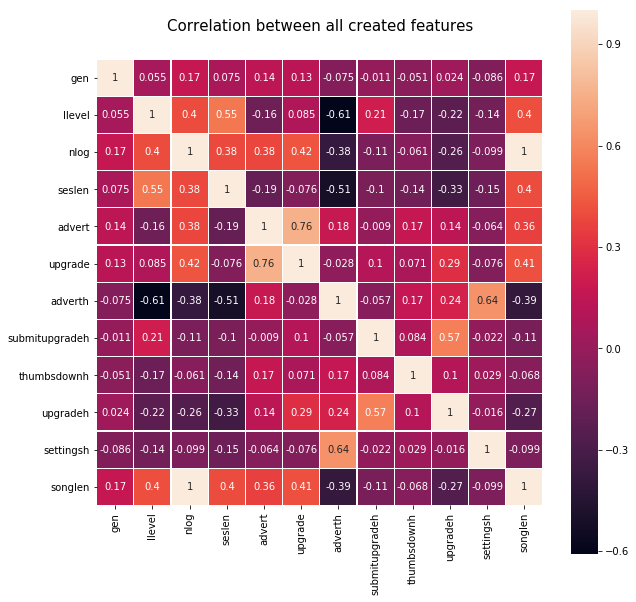

In [729]:
# correlation heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation between all created features', y=1.05, size=15)
sb.heatmap(model_df.iloc[:, 1:].corr(),linewidths=0.1,vmax=1.0, 
            square=True,annot=True);

In [715]:
modelSchema = StructType([ \
                    StructField("label", IntegerType(), False) \
                    ,StructField("gen", IntegerType(), False) \
                    ,StructField("llevel", IntegerType(), False) \
                    ,StructField("nlog", IntegerType(), False) \
                    ,StructField("seslen", FloatType(), False) \
                    ,StructField("advert", IntegerType(), False) \
                    ,StructField("upgrade", IntegerType(), False) \
                    ,StructField("adverth", FloatType(), False) \
                    ,StructField("submitupgradeh", FloatType(), False) \
                    ,StructField("thumbsdownh", FloatType(), False) \
                    ,StructField("upgradeh", FloatType(), False) \
                    ,StructField("settingsh", FloatType(), False) \
                    ,StructField("songlen", FloatType(), False) \
                         ])
data2 = spark.createDataFrame(model_df, schema=modelSchema)
data2.printSchema()

root
 |-- label: integer (nullable = false)
 |-- gen: integer (nullable = false)
 |-- llevel: integer (nullable = false)
 |-- nlog: integer (nullable = false)
 |-- seslen: float (nullable = false)
 |-- advert: integer (nullable = false)
 |-- upgrade: integer (nullable = false)
 |-- adverth: float (nullable = false)
 |-- submitupgradeh: float (nullable = false)
 |-- thumbsdownh: float (nullable = false)
 |-- upgradeh: float (nullable = false)
 |-- settingsh: float (nullable = false)
 |-- songlen: float (nullable = false)



In [716]:
model_data = spark.createDataFrame(model_df, schema=modelSchema)

In [717]:
model_data.show(5)

+-----+---+------+----+---------+------+-------+-----------+--------------+-----------+-----------+----------+----------+
|label|gen|llevel|nlog|   seslen|advert|upgrade|    adverth|submitupgradeh|thumbsdownh|   upgradeh| settingsh|   songlen|
+-----+---+------+----+---------+------+-------+-----------+--------------+-----------+-----------+----------+----------+
|    0|  1|     0| 381|154.48334|    52|      2|  2.8851933|           0.0| 0.27742243| 0.11096898|       0.0|   66940.9|
|    0|  0|     1| 474|    266.4|     7|      2| 0.26276276|   0.037537538| 0.22522523|0.075075075|0.11261261| 94008.875|
|    1|  0|     0|  11|29.566668|     1|      0|  2.0304568|           0.0|        0.0|        0.0|       0.0|  2089.113|
|    0|  1|     1|4825|578.99426|     4|      0|0.014293513|           0.0| 0.14650851|        0.0|0.07146756|1012312.06|
|    1|  0|     1|2464| 872.3567|     0|      0|        0.0|           0.0|  0.1444758|        0.0| 0.0825576| 523275.84|
+-----+---+------+----+-

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [482]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#### VectorAssembler

In [718]:
features = model_data.columns[1:]
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
model_data = assembler.transform(model_data)

In [719]:
model_data.printSchema()

root
 |-- label: integer (nullable = false)
 |-- gen: integer (nullable = false)
 |-- llevel: integer (nullable = false)
 |-- nlog: integer (nullable = false)
 |-- seslen: float (nullable = false)
 |-- advert: integer (nullable = false)
 |-- upgrade: integer (nullable = false)
 |-- adverth: float (nullable = false)
 |-- submitupgradeh: float (nullable = false)
 |-- thumbsdownh: float (nullable = false)
 |-- upgradeh: float (nullable = false)
 |-- settingsh: float (nullable = false)
 |-- songlen: float (nullable = false)
 |-- NumFeatures: vector (nullable = true)



#### Scaler

In [720]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(model_data)
model_data = scalerModel.transform(model_data)

#### GBT Classifier

##### churn

0.6730769230769231
0.65579133510168


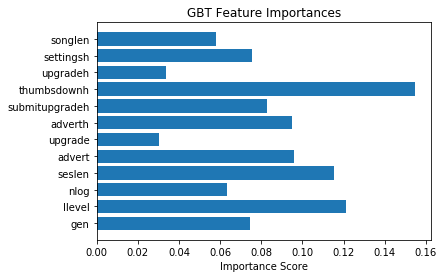

In [721]:
# split data
model_data2 = model_data.select('label', 'features')
train,validation = model_data2.randomSplit([0.8, 0.2], seed=42)

# models to train: logistic regression, svm, gradient boosting tree
gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

# important features
importances = list(gbt_model.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

##### churn2

0.7307692307692307
0.7260950854700854


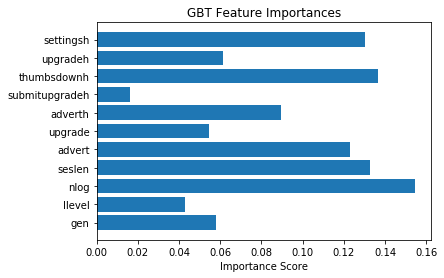

In [691]:
# split data
model_data2 = model_data.select('label', 'features')
train,validation = model_data2.randomSplit([0.8, 0.2], seed=42)

# models to train: logistic regression, svm, gradient boosting tree
gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

# important features
importances = list(gbt_model.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

0.7115384615384616
0.6962864721485411


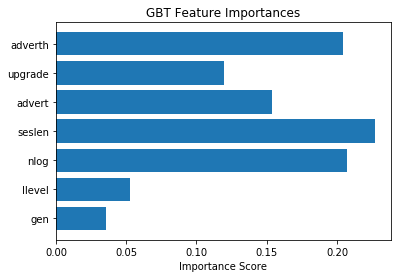

In [675]:
# split data
model_data2 = model_data.select('label', 'features')
train,validation = model_data2.randomSplit([0.8, 0.2], seed=42)

# models to train: logistic regression, svm, gradient boosting tree
gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

# important features
importances = list(gbt_model.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

#### ML

In [619]:
model_data2 = model_data.select('label', 'features')
train,validation = model_data2.randomSplit([0.8, 0.2], seed=42)

In [692]:
# Models to train: logistic regression, svm, gradient boosting tree
logistic_reg = LogisticRegression(maxIter=10, regParam = 0.0)
gbt = GBTClassifier(maxDepth = 5, maxIter = 10, seed = 42)
svm = LinearSVC (maxIter = 10, regParam = 0.01)

##### Logistic Regression

In [693]:
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.7507988581567837, 0.6944761882024696, 0.6852126107537875]

In [620]:
e1 = MulticlassClassificationEvaluator(metricName='f1')
paramGrid = ParamGridBuilder() \
    .addGrid(logistic_reg.regParam,[0.0, 0.05, 0.1]) \
    .build()
crossval = CrossValidator(estimator=logistic_reg,
                          estimatorParamMaps=paramGrid,
                          evaluator=e1,
                          numFolds=3)
cvModel_q1 = crossval.fit(train)
cvModel_q1.avgMetrics

[0.7757843885075006, 0.7669136403776244, 0.7629631705286708]

##### GBTClassifier

In [621]:
gbt_tuned = GBTClassifier(maxDepth=5, maxIter=10, seed=42)
gbt_model = gbt_tuned.fit(train)
results = gbt_model.transform(validation)

In [622]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [623]:
print(evaluator.evaluate(results, {evaluator.metricName: "accuracy"}))

0.7884615384615384


In [624]:
print(evaluator.evaluate(results, {evaluator.metricName: "f1"}))

0.7825724871681565


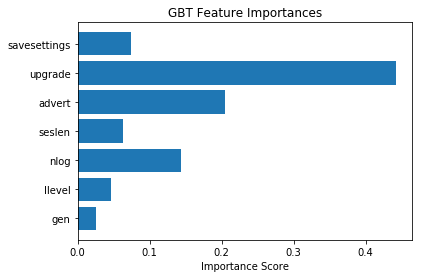

In [625]:
importances = list(gbt_model.featureImportances)
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances')
plt.savefig('GBT feature Importance.png', dpi=72)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.